In [1]:
import os
import sys
import json
import copy
import pmdarima
import datetime
import importlib
import numpy as np
import cvxpy as cp
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from Code.case_1 import case_1
from Code.case_2 import case_2
from Code.case_3 import case_3
from Code.case_4 import case_4

from Code.case_1 import plot_case_1
from Code.case_2 import plot_case_2
from Code.case_3 import plot_case_3
from Code.case_4 import plot_case_4

from Code.plot_case_1_3 import plot_case_1_3

import Code.case_3

import random
random.seed(50)

In [2]:
class MPC(object):
    def __init__(self, data, filename):
        self.data_list = data

        params = json.load(open(filename))

        self.dt   = params['dt']
        self.lam  = params['lambda']
        self.eta  = params['eta']
        self.case = params['case']

        self.chg_power    = params['chg_power']    #kW
        self.batt_energy  = params['batt_energy']  # kWh
        self.dischg_power = params['dischg_power'] # kW
        self.transformer_limit = params['transformer_limit'] # kW
        
        self.soc_init  = params['soc_init']
        self.num_homes = params['num_homes']

        self.mpc_horizon      = params['mpc_horizon']
        self.total_horizon    = params['total_horizon']
        self.forecast_days    = params['forecast_days']
        self.num_timesteps    = int(self.mpc_horizon / self.dt)
        self.num_mpc_iters    = int(self.total_horizon  / self.dt)
        self.ev_forecast_days = params['ev_forecast_days']
        
        #PG&E TOU -- effective April 1, 2014
        self.peak_summer = 0.66 # $/kWh
        self.partial_peak_summer = 0.55 # $/kWh
        self.off_peak_summer = 0.35 # $/kWh
        self.peak_winter = 0.54 # $/kWh
        self.partial_peak_winter = 0.52 # $/kWh
        self.off_peak_winter = 0.35 # $/kWh

        #Austin TOU
        # self.peak         = 0.08961
        # self.off_peak     = 0.02841
        # self.partial_peak = 0.04371

        self.colorset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']

    def reshape_data(self):
        ## downsample the data so that each index moves at the 
        ## the timestep of interest ( for example take a dataset
        ## that steps every 15 minutes and change it to every 30 
        ## minutes instead )
        ## average out data to fit MPC - downsampling only!

        for home in range(self.num_homes):
            temp = pd.DataFrame(columns = ['datetime', 'solar', 'loads', 'ev'])
            self.data_temp = self.data_list[home]
            current_dt = (self.data_temp.datetime[1].minute - self.data_temp.datetime[0].minute) / 60
            sampling_rate = int(self.dt/current_dt)
            temp.datetime = self.data_temp.datetime[1::sampling_rate]
            
            temp.solar = np.average(np.array(self.data_temp.solar).reshape(-1, sampling_rate), axis=1)
            temp.loads = np.average(np.array(self.data_temp.loads).reshape(-1, sampling_rate), axis=1)
            temp.ev    = np.average(np.array(self.data_temp.loads).reshape(-1, sampling_rate), axis=1)
            
            self.data_temp = temp
            self.data_temp = self.data_temp.reset_index(drop=True)
            self.data_list[home] = self.data_temp

    def run_mpc(self, solar, loads, timesteps, num_homes, time_vec, soc_init = .5):

        if self.case ==1:
            meter, batt_output, costs, SOCs = case_1(self, solar, loads, timesteps, num_homes, time_vec, soc_init)
        if self.case ==2:
            meter, batt_output, costs, SOCs = case_2(self, solar, loads, timesteps, num_homes, time_vec, soc_init)
        if self.case ==3:
            meter, batt_output, costs, SOCs = Code.case_3.case_3(self, solar, loads, timesteps, num_homes, time_vec, soc_init)
        if self.case ==4:
            meter, batt_output, costs, SOCs = case_4(self, solar, loads, timesteps, num_homes, time_vec, soc_init)

        return meter, batt_output, costs, SOCs
    
    def take_mpc_step(self, soc_old, batt_output, time):
        # add ev loads to home loads (not combined together anymore)
        soc_new = soc_old - self.dt * batt_output / self.batt_energy
        solar_actual = np.zeros((self.num_homes,))
        loads_actual = np.zeros((self.num_homes,))
        for home in range(self.num_homes):
            solar_actual[home] = self.data_list[home].loc[np.where(self.data_list[home].loc[:, 'datetime']==time)[0][0], 'solar']
            loads_actual[home] = self.data_list[home].loc[np.where(self.data_list[home].loc[:, 'datetime']==time)[0][0], 'loads'] + self.data_list[home].loc[np.where(self.data_list[home].loc[:, 'datetime']==time)[0][0], 'ev']

        # check if there are cases where the battery is set to charge when the loads are high
        # if so just set those values equal to 0
        # loc = np.where((loads_actual - solar_actual) >= 5)[0]
        # for ix in loc:
        #     if batt_output[ix] < 0:
        #         batt_output[ix] = 0

        meter = -solar_actual + loads_actual - batt_output
        
        return soc_new, meter
    
    def calc_mpc_cost(self, meter, num_homes, time_vec, batt_output=None, no_bess_val=False):
        timesteps = len(time_vec)
        price_vector = np.zeros((timesteps,))
        for time in range(timesteps):
            # weekend - off peak
            if time_vec[time].weekday() == 5 or time_vec[time].weekday() == 6:
                price_vector[time] = self.off_peak
            else: #weekday
                if time_vec[time].hour < 7 or time_vec[time].hour >=22: #off peak
                    price_vector[time] = self.off_peak
                elif time_vec[time].hour>=15 and time_vec[time].hour<18: #peak
                    price_vector[time] = self.peak
                else: #off peak
                    price_vector[time] = self.partial_peak

        if no_bess_val:
            cost_vec = np.zeros((num_homes,))
            for home in range(num_homes):
                cost_vec[home]= np.maximum(meter[:, home],0) * self.dt @ price_vector
        elif self.case ==1 or self.case == 4:
            cost_vec = np.zeros((num_homes,))
            for home in range(num_homes):
                cost_vec[home]= np.maximum(meter[:, home] -  batt_output[:, home], 0) * self.dt @ price_vector

        # elif self.case==3 or self.case==4:
        elif self.case == 3:
            combined_cost =  np.maximum(np.sum(meter, axis=1) -  batt_output[:, 0],0 ) * self.dt @ price_vector
            cost_vec = np.zeros((num_homes,))
            orig_costs = np.zeros((num_homes,), dtype='float32')
            for home in range(num_homes):
                orig_costs[home] = np.maximum(meter[:, home],0) * self.dt @ price_vector
        
            for home in range(num_homes):
                cost_vec[home] = orig_costs[home] / np.sum(orig_costs) * combined_cost
        

        return cost_vec

    def getDates(self, startDate):
        for timestep in range(self.num_timesteps):
            yield [startDate - datetime.timedelta(days  = self.forecast_days) + \
                               datetime.timedelta(hours = timestep * self.dt) + \
                               datetime.timedelta(days  = day) for day in range(self.forecast_days)]
    
    def forecastPlots(self, forecast_df, f, f2, start):
             
        dates = list(self.getDates(start))
        if self.num_homes>1:
            fig, axes = plt.subplots(self.num_homes,1)
            for home in range(self.num_homes):
                count=0
                for currentDay in np.array(dates).transpose():
                    
                    solar = self.data_list[home].loc[np.isin(self.data_list[home].datetime, currentDay), 'solar']
                    # axes[home].plot(forecast_df.datetime, solar, color=self.colorset[count+2], label='Day '+ str(count))
                    axes[home].plot(forecast_df.datetime, solar, color=self.colorset[count], label='Day '+ str(count))
                    count+=1

                times  = [d[0] + datetime.timedelta(days = self.forecast_days) for d in dates]
                currDF = self.data_list[home][np.isin(self.data_list[home].datetime, times)]
                axes[home].plot(forecast_df.datetime, f[home]["solar_mean"],color=self.colorset[1],  label = 'avg')
                axes[home].plot(currDF.datetime, currDF.solar, color=self.colorset[0], label = 'actual')
                axes[home].set_ylabel('Power [kw]')
                axes[home].legend()

            # Plot Solar
            fig, axes = plt.subplots(self.num_homes,1)

            times  = [d[0] + datetime.timedelta(days = self.forecast_days) for d in dates]
            currDF = self.data_list[0][np.isin(self.data_list[0].datetime, times)]

            for home in range(self.num_homes):
                currDF = self.data_list[home][np.isin(self.data_list[home].datetime, times)]
                axes[home].plot(currDF.datetime, currDF.solar, color=self.colorset[0], label = 'actual')
                axes[home].plot(forecast_df.datetime, f[home]["solar_mean"], color=self.colorset[1], label = "avg")
                axes[home].set_ylabel('Power [kw]')
                axes[home].legend()
            plt.title('Solar')
            plt.show()

            # Plot Loads 
            fig, axes = plt.subplots(self.num_homes,1)
            for home in range(self.num_homes):
                currDF = self.data_list[home][np.isin(self.data_list[0].datetime, times)]
                axes[home].plot(currDF.datetime, currDF.loads,color=self.colorset[0], label = 'Actual')
                axes[home].plot(forecast_df.datetime, f[home]["loads_mean"],color=self.colorset[1], label = "Prediction")
                axes[home].set_ylabel('Power [kw]')
                axes[home].legend()
            plt.title('Loads')
            plt.show()

            fig, axes = plt.subplots(2,1, figsize=(6,6))
            currDF = self.data_list[0][np.isin(self.data_list[0].datetime, times)]
            axes[0].plot(np.arange(len(currDF.datetime)), currDF.solar,color='0', label = 'Actual Solar', linewidth=2)
            axes[0].plot(np.arange(len(forecast_df.datetime)), f[0]["solar_mean"],color=self.colorset[1], label = 'Forecast Solar', linewidth=2)
            #axes[0].plot(np.arange(len(forecast_df.datetime)), f2[0]["solar_mean"],color=self.colorset[2], label = 'Conservative Forecast Solar', linewidth=2)

            axes[0].set_ylabel('Power [kW]', fontsize=14)

            axes[0].legend(fontsize=11, loc=1)
            axes[0].set_xticks(range(0,len(forecast_df.datetime)+1,8))
            axes[0].set_xticklabels(range(0,24+1,4))
            axes[0].tick_params(axis='both', which='major', labelsize=11)
            #axes[0].xaxis.set_tick_params(labelbottom=False)
            currDF = self.data_list[0][np.isin(self.data_list[0].datetime, times)]
            axes[1].plot(np.arange(len(currDF.datetime)), currDF.loads,color='0', label = 'Actual Loads', linewidth=2)
            axes[1].plot(np.arange(len(forecast_df.datetime)), f[0]["loads_mean"], color=self.colorset[1], label = "Forecast Loads", linewidth=2)
            #axes[1].plot(np.arange(len(forecast_df.datetime)), f2[0]["loads_mean"], color=self.colorset[2], label = "Conservative Forecast Loads", linewidth=2)

            axes[1].set_ylabel('Power [kW]', fontsize=14)
            axes[1].legend(fontsize=11, loc=1)
            axes[1].set_xlabel('Time [hr]', fontsize=14)
            axes[1].set_xticks(range(0,len(forecast_df.datetime)+1,8))
            axes[1].set_xticklabels(range(0,24+1,4))
            axes[1].set_ylim([0,max(currDF.loads)*1.1])
            axes[1].tick_params(axis='both', which='major', labelsize=11)
            #plt.setp(axes, xticks=range(0,len(forecast_df.datetime),8), xticklabels=range(0,24,4))
            plt.savefig('Figures/forecast.pdf', bbox_inches='tight')
            plt.savefig('Figures/forecast.png', bbox_inches='tight')
            plt.show()

            print('Day = ' + str(start))
            solar_mape= []
            loads_mape = []
            for home in range(self.num_homes):
                solar_mape.append(abs((sum(self.data_list[home][np.isin(self.data_list[0].datetime, times)].solar)-sum(f[home]["solar_mean"]))/sum(self.data_list[0][np.isin(self.data_list[0].datetime, times)].solar)))
                loads_mape.append(abs((sum(self.data_list[home][np.isin(self.data_list[0].datetime, times)].loads)-sum(f[home]["loads_mean"]))/sum(self.data_list[0][np.isin(self.data_list[0].datetime, times)].loads)))
            solar_mape_final = (1/self.num_homes) * sum(solar_mape)
            loads_mape_final = (1/self.num_homes) * sum(loads_mape)
            print('Solar MAPE = ' + str(solar_mape_final))
            print('Loads MAPE = ' + str(loads_mape_final))


        else:
            fig, axes = plt.subplots(self.num_homes,1)
            for currentDay in np.array(dates).transpose():
                solar = self.data_list[0][np.isin(self.data_list[0].datetime, currentDay)].solar
                axes.plot(forecast_df.datetime, solar)

            axes.plot(forecast_df.datetime, f[0]["solar_mean"], color=self.colorset[1], label = 'avg')
            axes.set_ylabel('Power [kw]')
            axes.legend()
            
            plt.show()

            fig, axes = plt.subplots(self.num_homes,1)

            times  = [d[0] + datetime.timedelta(days = self.forecast_days) for d in dates]
            currDF = self.data_list[0][np.isin(self.data_list[0].datetime, times)]

            
            axes.plot(currDF.datetime, currDF.solar, color=self.colorset[0], label = 'actual')
            axes.plot(forecast_df.datetime, f[0]["solar_mean"], color=self.colorset[1], label = "avg")
            axes.set_ylabel('Power [kw]')
            axes.legend()
            plt.title('Solar')
            plt.show()

            fig, axes = plt.subplots(self.num_homes,1)
            
            axes.plot(currDF.datetime, currDF.loads, color=self.colorset[0], label = 'Actual')
            axes.plot(forecast_df.datetime, f[0]["loads_mean"], color=self.colorset[1], label = "Prediction")
            axes.set_ylabel('Power [kw]')
            axes.legend()
            plt.title('Loads')
            plt.show()
        
        return
    
    def return_forecast(self, start, plotting=False, forecast_type=1):
        forecast_df = pd.DataFrame(columns = ['datetime'])
        forecast_df.loc[0, 'datetime'] = start 

        for timestep in range(1, self.num_timesteps):
            forecast_df.loc[timestep, 'datetime'] = forecast_df.loc[0, 'datetime'] + timestep * datetime.timedelta(hours=self.dt)

        f = [{"solar_mean" : [], 
              "loads_mean" : [],  
              "ev_mean"    : []} for home in range(self.num_homes)]
    
        # forecast = 1 refers to the average of the past X days where 
        # X refers to the value specified in self.forecast_days
        # forecast = 2 takes the average of the past X days as well, 
        # but multiplies this average solar value by 0.8 and the loads
        # by 1.2 ultimately scaling down the solar and scaling up the loads

        if forecast_type==1:
            for timestep in range(self.num_timesteps):
                avg_idxs    = []
                ev_avg_idxs = []

                for day in range(self.forecast_days):
                    avg_idxs.append(np.where(self.data_list[0].loc[:, 'datetime'] == start - datetime.timedelta(days=self.forecast_days) + datetime.timedelta(hours = timestep * self.dt) + datetime.timedelta(days=day))[0][0])

                if self.ev_forecast_days != 0:
                    for day in range(self.ev_forecast_days):
                        ev_avg_idxs.append(np.where(self.data_list[0].loc[:, 'datetime'] == start - datetime.timedelta(days=self.ev_forecast_days) + datetime.timedelta(hours = timestep * self.dt) + datetime.timedelta(days=day))[0][0])
                else:
                    ev_avg_idxs.append(np.where(self.data_list[0].loc[:, 'datetime'] == start + datetime.timedelta(hours = timestep * self.dt))[0][0])
                    #print("ev_avg_idxs = {}".format(ev_avg_idxs))
                    #assert(True == False)
                
                for home in range(self.num_homes):

                    f[home]["solar_mean"].append(np.average(self.data_list[home].loc[avg_idxs, 'solar']))
                    f[home]["loads_mean"].append(np.average(self.data_list[home].loc[avg_idxs, 'loads']))
                    f[home]["ev_mean"].append(np.average(self.data_list[home].loc[ev_avg_idxs, 'ev']))
                
        if forecast_type==2:
            for timestep in range(self.num_timesteps):
                avg_idxs = []
                for day in range(self.forecast_days):
                    avg_idxs.append(np.where(self.data_list[0].loc[:, 'datetime'] == start - datetime.timedelta(days=self.forecast_days) + datetime.timedelta(hours = timestep * self.dt) + datetime.timedelta(days=day))[0][0])
                
                for home in range(self.num_homes):

                    f[home]["solar_mean"].append(np.average(self.data_list[home].loc[avg_idxs, 'solar']) * 0.8)
                    f[home]["loads_mean"].append(np.average(self.data_list[home].loc[avg_idxs, 'loads']) * 1.2)
            
        
        solar = np.zeros((len(forecast_df.datetime), self.num_homes))
        loads = np.zeros((len(forecast_df.datetime), self.num_homes))

        # print(len(forecast_df.datetime))

        for home in range(self.num_homes):
            # print("home = {} len of loads = {} len of ev = {} len of solar = {}".format(home, len(f[home]["loads_mean"]), len(f[home]["ev_mean"]), len(f[home]["solar_mean"])))
            solar[:, home] = f[home]["solar_mean"] 
            loads[:, home] = np.array(f[home]["loads_mean"]) + np.array(f[home]["ev_mean"])

        if plotting:
            # a bit of plotting
            f2 = [{"solar_mean" : [], 
              "loads_mean" : []} for home in range(self.num_homes)]
            for timestep in range(self.num_timesteps):
                avg_idxs = []
                for day in range(self.forecast_days):
                    avg_idxs.append(np.where(self.data_list[0].loc[:, 'datetime'] == start - datetime.timedelta(days=self.forecast_days) + datetime.timedelta(hours = timestep * self.dt) + datetime.timedelta(days=day))[0][0])
                
                for home in range(self.num_homes):

                    f2[home]["solar_mean"].append(np.average(self.data_list[home].loc[avg_idxs, 'solar']) * 0.8)
                    f2[home]["loads_mean"].append(np.average(self.data_list[home].loc[avg_idxs, 'loads']) * 1.2)
            self.forecastPlots(forecast_df, f, f2, start)
            
        return forecast_df.datetime, solar, loads


    def deterministic_mpc(self, start_date, plotting = False, forecast = 1):

        meter       = np.zeros((self.num_mpc_iters, self.num_homes))
        batt_output = np.zeros((self.num_mpc_iters, self.num_homes))
        soc_init    = np.zeros((self.num_mpc_iters+1, self.num_homes))

        # for case 4 we are running both the individual and joint optimization cases together
        # this means that we need to pass in two different initSOCs ... one that represents
        # the initSOC for each of the inidivdual batteries and another that represents the
        # initSOCs of the batteries used for joint optimization

        if self.case == 4:
            soc_double = np.zeros((2, self.num_homes))
            soc_double[0, :] = self.soc_init
            soc_double[1, :] = self.soc_init

        soc_init[0, :] = self.soc_init
        batt_vec_list  = []

        for mpc_iter in range(self.num_mpc_iters):
            print(str(mpc_iter+1) + ' iteration out of ' + str(self.num_mpc_iters) + ' MPC iterations')
            time = start_date + datetime.timedelta(hours = mpc_iter * self.dt)

            dates, solar, loads = self.return_forecast(time, plotting = False, forecast_type = forecast)
            
            if self.case == 4:
                m, b, cost_vec, soc = self.run_mpc(solar, loads, self.num_timesteps, self.num_homes, dates, soc_init = soc_double)
                soc_double[0, :], iMeter = self.take_mpc_step(soc_double[0, :], b[-2, :], time)
                soc_double[1, :], jMeter = self.take_mpc_step(soc_double[1, :], b[-1, :], time)
            else:
                m, b, cost_vec, soc = self.run_mpc(solar, loads, self.num_timesteps, self.num_homes, dates, soc_init = soc_init[mpc_iter, :])

            batt_output[mpc_iter, :] = b[0, :]
            soc_init[mpc_iter+1, :], meter[mpc_iter, :] = self.take_mpc_step(soc_init[mpc_iter, :], batt_output[mpc_iter, :], time)

            batt_vec_list.append(b)

        if plotting:
            start_idx = np.where(self.data_list[0].loc[:, 'datetime']==start_date)[0][0]
            end_idx = np.where(self.data_list[0].loc[:, 'datetime']==start_date + datetime.timedelta(hours = self.total_horizon-self.dt) )[0][0] 
            fig, axes = plt.subplots(int(b.shape[1]),1)
            
            if b.shape[1]>1:
                for home in range(b.shape[1]):
                    for iter in range(0,len(batt_vec_list),4):
                        date = self.data_list[0].loc[start_idx+iter:np.minimum(end_idx,start_idx+iter+self.num_timesteps-1), 'datetime'].values
                        axes[home].plot(date, batt_vec_list[iter][:len(date), home], color = self.colorset[1])
                    axes[home].plot(self.data_list[0].loc[start_idx:end_idx, 'datetime'].values, batt_output[:, home], label = 'Actual Output', color = self.colorset[0])
                    axes[home].set_ylabel('Power [kW]')
            else:
                for iter in range(0,len(batt_vec_list),4):
                    date = self.data_list[0].loc[start_idx+iter:np.minimum(end_idx,start_idx+iter+self.num_timesteps-1), 'datetime'].values
                    axes.plot(date, batt_vec_list[iter][:len(date)], color = self.colorset[1])
                axes.plot(self.data_list[0].loc[start_idx:end_idx, 'datetime'].values, batt_output, label = 'Actual Output', color = self.colorset[0])
                axes.set_ylabel('Power [kW]')

            plt.xlabel('Date')
            
            plt.legend()
            plt.show()

        start_idx = np.where(self.data_list[0].loc[:, 'datetime']==start_date)[0][0]
        end_idx = np.where(self.data_list[0].loc[:, 'datetime']==start_date + datetime.timedelta(hours = self.total_horizon - self.dt))[0][0] 
        time_vec = self.data_list[0].loc[start_idx:end_idx, 'datetime'].values
        
        # add EV values to this data
        no_bess = np.zeros((len(time_vec), self.num_homes))
        for home in range(self.num_homes):
            no_bess[:, home] = self.data_list[home].loc[start_idx:end_idx, 'loads'].values + self.data_list[home].loc[start_idx:end_idx, 'ev'].values - self.data_list[home].loc[start_idx:end_idx, 'solar'].values

        cost_vec = self.calc_mpc_cost(no_bess, self.num_homes, time_vec, batt_output)

        print('Total MPC cost is: ', np.sum(cost_vec))
        print('cost of each home is: ', cost_vec)
        
        if self.num_homes >1:
            cost_vec_no_bess = self.calc_mpc_cost(no_bess, self.num_homes, time_vec, batt_output=None, no_bess_val=True)
        else:
            cost_vec_no_bess = self.calc_mpc_cost(no_bess.reshape(-1,1), self.num_homes, time_vec, batt_output=None, no_bess_val=True)

        print('Total cost without BESS: ', np.sum(cost_vec_no_bess))
        print('cost of each home is: ', cost_vec_no_bess)

        return meter, batt_output, soc_init, cost_vec, cost_vec_no_bess

    def full_deterministic(self, start_date, plotting=False):
        solar     = np.zeros((self.num_mpc_iters, self.num_homes))
        loads     = np.zeros((self.num_mpc_iters, self.num_homes))
        soc_init  = np.zeros((self.num_homes,))

        if self.case == 4:
            soc_init = np.zeros((2, self.num_homes))
            soc_init[0, :] = self.soc_init
            soc_init[1, :] = self.soc_init
        else:
            soc_init[:] = self.soc_init

        for home in range(self.num_homes):
            mask = self.data_list[home][(self.data_list[home].datetime >= start_date) & (self.data_list[home].datetime <  start_date + datetime.timedelta(hours = self.total_horizon))].index
            solar[:, home] = self.data_list[home].loc[mask, 'solar']
            loads[:, home] = self.data_list[home].loc[mask, 'loads'] + self.data_list[home].loc[mask, 'ev']
            # time_vec       = self.data_list[home].loc[mask].datetime
            time_vec       = self.data_list[home].loc[mask].datetime.values

        print(solar.sum(axis = 1)[173])
        print((loads.sum(axis = 1) - solar.sum(axis = 1))[173])
 
        meter_amount, batt_output, cost_vec, soc_output = self.run_mpc(solar, loads, self.num_mpc_iters, self.num_homes, time_vec, soc_init)

        print(meter_amount.sum(axis = 1)[173])
        
        print('Total full deterministic cost is: ', np.sum(cost_vec))
        print('cost of each home is: ', cost_vec)

        return meter_amount, batt_output, soc_output, cost_vec

In [3]:
def process_data(filename, add_EV_to_loads = True):
    data = pd.read_csv(filename)
    #data = data.rename(columns={'Date & Time':'datetime', 'Solar [kW]':'solar', 'Grid [kW]':'loads', 'EV Loads [kW]':'ev'})
    data = data.rename(columns={'loads [kW]':'loads', 'solar [kW]':'solar', 'ev (kW)':'ev'}) # new files
    #data = data.rename(columns={'Date & Time':'datetime', 'Solar [kW]':'solar', 'EV Loads[kW]':'ev'}) # old files
    #data.loads += data.solar
    
    #data.datetime = pd.to_datetime(data.datetime)
    #data cleaning:
    data.loc[np.where(data.solar < 0)[0][:], 'solar'] = 0
    data.loc[np.where(data.ev < 0.01)[0][:], 'ev'] = 0

    #data.solar[data.solar < 0] = 0
    #data.ev[data.ev < 0.01] = 0

    # solar and loads are currently reported in kWh every 15 minutes
    # divide all the data in these columns by 15/60 hours so that you
    # convert the energy consumed to the corresponding kW during that 
    # 15 minute time window
    data.loads = data.loads / (15/60)
    data.solar = data.solar / (15/60)

    # add EV data to loads - if not already pre-processed
    if add_EV_to_loads:
        data.loads += data.ev

    for i in range(len(data.datetime)):
        data.loc[i, 'datetime'] = parser.parse(str(data.loc[i,'datetime'])) # datetime.datetime.strptime(str(data.loc[i,'datetime']), '%Y-%m-%d %H:%M:%S')
        data.loc[i, 'datetime'] = datetime.datetime.replace(data.loc[i, 'datetime'], tzinfo=None)
    return data

def cost_savings(no_bess, indiv, joint):
    indiv_save = []
    joint_save = []
    for home in range(len(no_bess)):
        indiv_save.append((no_bess[home] - indiv[home])/no_bess[home])
        joint_save.append((no_bess[home] - joint[home])/no_bess[home])

    print('indiv savings: ', np.average(indiv_save))
    print('joint savings: ', np.average(joint_save))
    return np.average(indiv_save), np.average(joint_save)

def run_case(mpc, start, path, case):
    meter0, battery0, soc0, cost_bess, cost_no_bess = mpc.deterministic_mpc(start, plotting = False, forecast=1)
    meter1, battery1, soc1, costD = mpc.full_deterministic(start)

    np.savetxt("{}/soc_d.csv".format(path), soc1)
    np.savetxt("{}/soc_d_mpc.csv".format(path), soc0)
    np.savetxt("{}/meter_d.csv".format(path), meter1)
    np.savetxt("{}/meter_d_mpc.csv".format(path), meter0)
    np.savetxt("{}/batt_output_d.csv".format(path), battery1)
    np.savetxt("{}/batt_output_d_mpc.csv".format(path), battery0)
    np.savetxt("{}/cost_list_determ_{}.csv".format(path, case), costD)
    np.savetxt("{}/cost_list_mpc_{}.csv".format(path, case), cost_bess)
    np.savetxt("{}/cost_list_{}_no_bess.csv".format(path, case), cost_no_bess)

def sizeSolar(data, average_peak_hours = 5.3, inefficiency_factor = 1.2):
    # process for solar sizing is outlined as below
    # 1. determine the average daily kWh consumption from the home
    # 2. determine the average daily peak hours in the city in which panels are located
    # 3. divide (1) by (2) to determine the power output of the panels
    # 4. account for any inefficiencies in the system (multiplying (3) by 1.2 is a good choice)
    # 5. reference : https://www.gogreensolar.com/pages/sizing-solar-systems

    ev_kWh    = sum(data.ev) / 4
    loads_kWh = sum(data.loads) / 4
    daily_kWh = (ev_kWh + loads_kWh)/365
    
    return round(daily_kWh / average_peak_hours * inefficiency_factor, 2)

In [4]:
def main():
    # print(sys.argv[1])
    if len(sys.argv) != 2:
        sys.exit("./optimization.py inputFileName")
    else:
        print("filename = {}".format(sys.argv[1]))
    #solar, loads, data = process_data(sys.argv[1])
    # temp_data = process_temp_data(5/60)
#    homeIDs   = [661, 4373, 4767, 6139, 7719, 8156, 1642, 8156, 1642]
#    createFileName = lambda start,end,ID: "Data_L2/data_{}_jan_{}_{}_l2.csv".format(ID, start, end)
    month = 7
    start_day = 1
#    start_day = 1
#   filenames = [createFileName(start_day, start_day + 10, ID) for ID in homeIDs]
    #filenames = [createFileName(start_day, start_day + 17, ID) for ID in homeIDs]

    # df = pd.read_csv('Data_L2/csv/102808-0.csv')

    # df["loads [kW]"] = df["loads [kW]"] / (15/60)
    # df["solar [kW]"] = df["solar [kW]"] / (15/60)

    # def convert_datetime(data):
    #     for i in range(len(data.datetime)):
    #         data.loc[i, 'datetime'] = parser.parse(str(data.loc[i,'datetime'])) # datetime.datetime.strptime(str(data.loc[i,'datetime']), '%Y-%m-%d %H:%M:%S')
    #         data.loc[i, 'datetime'] = datetime.datetime.replace(data.loc[i, 'datetime'], tzinfo=None)
    #     return data

    # IDs = [102808, 108199, 122340, 131172, 138546, 146132, 153948, 165637, 180477]

    # colors = ["xkcd:chocolate", "#04D8B2", "xkcd:azure", "xkcd:beige", "#000000", "xkcd:cyan", 
    #           "#653700", "#C1F80A", "#FC5A50", "#8C000F", "#054907", "#FF00FF", 
    #           "#FAC205", "#808080", "#380282", "#C79FEF", "#6E750E", "orangered", 
    #           "#580F41", "#FF0000", "#A9561E", "#008080", "#FFFF00", "#9ACD32"]

    # for ID in IDs:
        # df = process_data('Data_L2/csv/{}-0.csv'.format(ID), add_EV_to_loads=False)
        # df = pd.read_csv('Data_L2/loads/{}-0_loads.csv'.format(ID))
        # df = convert_datetime(df)

        # startIndex = np.where(df.datetime == datetime.datetime(2018, month, start_day, 0, 0))[0][0]
        # # print("startIndex = {}".format(startIndex))
        # print("the total loads of the year is {} and the total ev is {}".format(sum(df.loads) / 4, sum(df.ev) / 4))
        # print("{} Solar Size = {} kW and the maximum solar value = {} kW".format(ID, sizeSolar(df), max(df.solar)))
        # sys.exit()
        
        # plt.figure(figsize=(12, 8))

        # ix = 0
        # for col in df.columns:
        #     if col != "datetime" and col != "net" and col != "total":
        #         if max(df[col]) > 1.5:
        #             print("ix = {} and df.columns[ix] = {}".format(ix, col))
        #             plt.plot(df.datetime[startIndex:startIndex+672], df["{}".format(col)][startIndex:startIndex+672], label="{}".format(col), color=colors[ix])
        #             ix += 1
        # plt.legend()
        # plt.title("home: {} loads July 1-8, 2018".format(ID), fontsize=15)
        # plt.xlabel("Date", fontsize=15)
        # plt.ylabel("Power [kW]", fontsize = 15)
        # plt.savefig("Data_L2/loads/{}_loads.png".format(ID))
        # plt.show()
        # sys.exit()
        # startIndex = 17568

        # plt.figure(figsize=(12,8))
        # plt.plot(df.datetime[startIndex:startIndex+672], df["solar"][startIndex:startIndex+672], label = "solar")
        # plt.plot(df.datetime[startIndex:startIndex+672], df["loads"][startIndex:startIndex+672], label = "total home loads")
        # plt.plot(df.datetime[startIndex:startIndex+672], df["ev"][startIndex:startIndex+672], label = "ev")
        # plt.legend(loc = "upper left")
        # plt.title("home: {} energy profile July 1-8, 2018".format(ID), fontsize=15)
        # plt.xlabel("Date", fontsize=15)
        # plt.ylabel("Power [kW]", fontsize = 15)

        # plt.savefig("{}_july_1_7_2018_solar_loads_ev.png".format(ID))

    # print("date = {}".format(df.datetime[17568]))

    # assert(True == False)

    IDs = [102808, 108199, 122340, 131172, 138546, 146132, 153948, 165637, 180477]
    createFileName = lambda ID : "Data_L2/csv/{}-0.csv".format(ID)
    filenames = [createFileName(ID) for ID in IDs]

    # print(filenames)

    data = []

    for home_file in filenames:
        print("opening {} and storing into array".format(home_file))
        data.append(process_data(home_file, add_EV_to_loads = False))

    # size solar appropriately for loads
    for ix in range(len(data)):
        maxSolar      = max(data[ix].solar)
        currSolarSize = sizeSolar(data[ix])

        if currSolarSize > maxSolar:
            ratio = currSolarSize / maxSolar
            data[ix].solar *= ratio
        

#    start_date = datetime.datetime(2018, month, start_day + 4, 0 , 0)
    # start_date = datetime.datetime(2018, month, start_day + 4, 0 , 15)
    start_date = datetime.datetime(2018, month, start_day, 0 , 15)

    # forecast_1
    experiment_file = 'Code/Experiments/case1_9_homes.json'
    # mpc_problem = MPC(data, temp_data, experiment_file)
    mpc_problem = MPC(data, experiment_file)

    path = 'Code/Results/case_1_9_homes_l2/f1'
    run_case(mpc_problem, start_date, path, case=1)
    
    cost_list_mpc_1     = np.loadtxt("{}/cost_list_mpc_1.csv".format(path))
    cost_list_determ_1  = np.loadtxt("{}/cost_list_determ_1.csv".format(path))
    cost_list_1_no_bess = np.loadtxt("{}/cost_list_1_no_bess.csv".format(path))

    # forecast_3
    # experiment_file = 'Code/Experiments/case3_9_homes.json'
    # mpc_problem = MPC(data, experiment_file)

    # path = 'Code/Results/case_3_9_homes_l2/f1'
    # run_case(mpc_problem, start_date, path, case=3)

    # cost_list_mpc_3    = np.loadtxt("{}/cost_list_mpc_3.csv".format(path))
    # cost_list_determ_3 = np.loadtxt("{}/cost_list_determ_3.csv".format(path))
    # cost_list_3_no_bess = np.loadtxt("{}/cost_list_3_no_bess.csv".format(path))

    # forecast_4
    experiment_file = 'Code/Experiments/case4_9_homes.json'
    mpc_problem = MPC(data, experiment_file)
    
    path = 'Code/Results/case_4_9_homes_l2/f1'
    run_case(mpc_problem, start_date, path, case=4)

    cost_list_mpc_4     = np.loadtxt("{}/cost_list_mpc_4.csv".format(path))
    cost_list_determ_4  = np.loadtxt("{}/cost_list_determ_4.csv".format(path))
    cost_list_4_no_bess = np.loadtxt("{}/cost_list_4_no_bess.csv".format(path))

    # print and plot data

    print('PF cost savings')
    cost_savings(cost_list_4_no_bess, cost_list_determ_1, cost_list_determ_4)
    print('MPC cost savings')
    cost_savings(cost_list_4_no_bess, cost_list_mpc_1, cost_list_mpc_4)

    plot_case_1_3(mpc_problem, cost_list_4_no_bess, cost_list_mpc_1, cost_list_determ_1, cost_list_mpc_4, cost_list_determ_4, filename=sys.argv[1])
    return
    


#if __name__ == '__main__':
    #main()

In [5]:
def printMeter(meter, battery, case, isMPC):
    maxMeter = 0
    minMeter = 0
    
    if isMPC:
        maxMeter = meter.sum(axis = 1).max()
        minMeter = meter.sum(axis = 1).min()
    elif not isMPC and case == 1:
        maxMeter = meter.sum(axis = 1).max()
        minMeter = meter.sum(axis = 1).min()
    elif not isMPC and case == 3:
        maxMeter = (meter.sum(axis = 1) - battery.sum(axis = 1)).max()
        minMeter = (meter.sum(axis = 1) - battery.sum(axis = 1)).min()
    elif not isMPC and case == 4:
        maxMeter = (meter.sum(axis = 1) - battery[:-2, :].sum(axis = 1)).max()
        minMeter = (meter.sum(axis = 1) - battery[:-2, :].sum(axis = 1)).min()

    print("the max meter = {}".format(maxMeter))
    print("the min meter = {}".format(minMeter))

    return

def countViolations(meter, limit = 25, violation_time_steps = 2):
    new_meter = meter.reshape(-1, violation_time_steps)
    # new_meter = meter.sum(axis = 1).reshape(-1, violation_time_steps)
    iix = np.where((new_meter > [limit] * violation_time_steps).sum(axis = 1) == violation_time_steps)[0]

    # print(iix)
    return len(iix)

def printCost(meter_no_bess, battery_PF, battery_MPC, price_vector, case, dt = 0.5):
    no_bess = (np.maximum(meter_no_bess, 0) * dt).T @ price_vector
    
    if case == 3 or case == 4:
        meter_MPC = (meter_no_bess - battery_MPC).sum(axis = 0)
        meter_PF  = (meter_no_bess - battery_PF).sum(axis = 0)

        #print(meter_MPC.shape)
        
        mpc = (np.maximum(meter_no_bess.sum(axis = 1) - battery_MPC.sum(axis = 1), 0) * dt).T @ price_vector
        pf  = (np.maximum(meter_no_bess.sum(axis = 1) - battery_PF.sum(axis = 1), 0) * dt).T @ price_vector
    else:
        mpc = (np.maximum(meter_no_bess - battery_MPC, 0) * dt).T @ price_vector
        pf  = (np.maximum(meter_no_bess - battery_PF, 0) * dt).T @ price_vector

    # print(np.sum(no_bess))
    # print(np.sum(mpc))
    # print(np.sum(pf))


    # print([np.round(x, 2)[0] for x in no_bess])
    # print([np.round(x, 2) for x in mpc])
    # print([np.round(x, 2) for x in pf])

    return pf, mpc

def getMeters(trial):
    battery_PF    = []
    battery_MPC   = []
    meter_no_bess = []
    
    for case in (1, 3, 4):
        if case == 3:
            path = os.getcwd() + "/Code/Results/case_{}/".format(case)
        else:
            path = os.getcwd() + "/Code/Results/case_{}/f1/".format(case)
            
        path1 = os.getcwd() + "/Code/Results/case_{}".format(3)
        
        meter_no_bess.append(np.loadtxt(path1 + "/meter_d_{}_ev_forecast_0_trial_{}.csv".format(3, trial)))
        battery_PF.append(np.loadtxt(path + "/batt_output_d_{}_ev_forecast_0_trial_{}.csv".format(case, trial)))
        battery_MPC.append(np.loadtxt(path + "/batt_output_d_{}_mpc_forecast_0_trial_{}.csv".format(case, trial)))

        if case == 4:
            battery_PF[-1] = battery_PF[-1][:-2, :]
        
    return meter_no_bess[0], battery_MPC, battery_PF

In [6]:
def getCosts(meter, battery_PF, battery_MPC, price_vector, dt = 0.5):
    cost_no_bess = (np.maximum(meter, 0) * dt).T @ price_vector

    case_1_costs = []
    case_3_costs = []
    case_4_costs = []

    case_3_PF  = (np.maximum((meter - battery_PF[1]).sum(axis = 1), 0) * dt).T @ price_vector
    case_3_MPC = (np.maximum((meter - battery_MPC[1]).sum(axis = 1), 0)  * dt).T @ price_vector

    case_4_PF  = (np.maximum((meter - battery_PF[2]).sum(axis = 1), 0) * dt).T @ price_vector
    case_4_MPC = (np.maximum((meter - battery_MPC[2]).sum(axis = 1), 0)  * dt).T @ price_vector

    case_1_costs.append(cost_no_bess)
    case_1_costs.append((np.maximum(meter - battery_MPC[0], 0) * dt).T @ price_vector)
    case_1_costs.append((np.maximum(meter - battery_PF[0], 0)  * dt).T @ price_vector)

    case_3_costs.append(cost_no_bess)
    case_3_costs.append(np.array([cost_no_bess[ix] / np.sum(cost_no_bess) * case_3_MPC for ix in range(cost_no_bess.shape[0])]))
    case_3_costs.append(np.array([cost_no_bess[ix] / np.sum(cost_no_bess) * case_3_PF for ix in range(cost_no_bess.shape[0])]))

    case_4_costs.append(cost_no_bess)
    case_4_costs.append(np.array([cost_no_bess[ix] / np.sum(cost_no_bess) * case_4_MPC for ix in range(cost_no_bess.shape[0])]))
    case_4_costs.append(np.array([cost_no_bess[ix] / np.sum(cost_no_bess) * case_4_PF for ix in range(cost_no_bess.shape[0])]))
        
    return case_1_costs, case_3_costs, case_4_costs

In [14]:
def createPriceVector(mpc, dates, timesteps):
    price_vector = np.zeros((timesteps, 1))

    for timestep in range(timesteps):
        if dates[timestep].month >= 6 and dates[timestep].month < 10: 
            if dates[timestep].hour < 15:
                price_vector[timestep] = mpc.off_peak_summer
            elif dates[timestep].hour == 15 or dates[timestep].hour >= 21:
                price_vector[timestep] = mpc.peak_summer
            else:
                price_vector[timestep] = mpc.partial_peak_summer
        else:
            if dates[timestep].hour < 15:
                price_vector[timestep] = mpc.off_peak_winter
            elif dates[timestep].hour == 15 or dates[timestep].hour >= 21:
                price_vector[timestep] = mpc.peak_winter
            else:
                price_vector[timestep] = mpc.partial_peak_winter

    return price_vector

def getForecast(data, start, timesteps, dt = 0.5, forecast_period = 4):
    loads_actual = np.zeros((timesteps, 1))
    solar_actual = np.zeros((timesteps, 1))
    
    loads_forecast = np.zeros((timesteps, 1))
    solar_forecast = np.zeros((timesteps, 1))
    
    for timestep in range(timesteps):
        ix = []
        for day in range(forecast_period):
            ix.append(np.where(data.loc[:, 'datetime'] == start - datetime.timedelta(days  = forecast_period) + 
                                                                  datetime.timedelta(hours = timestep * dt) + 
                                                                  datetime.timedelta(days  = day))[0][0])
        loads_forecast[timestep, 0] = np.average(data.loc[ix, "loads"])
        solar_forecast[timestep, 0] = np.average(data.loc[ix, "solar"])

    mask = (data.datetime >= start) & (data.datetime < start + datetime.timedelta(hours = timesteps / 2))
    
    solar_actual[:, 0] = data.loc[mask, 'solar']
    loads_actual[:, 0] = data.loc[mask, 'loads']

    dates = data.loc[mask, "datetime"].reset_index(drop = True)

    return loads_forecast, solar_forecast, loads_actual, solar_actual, dates

def getFiles(folder_path, count, homes = 1, returnFiles = False):
    files = os.listdir(os.getcwd() + folder_path)
    files = [file for file in files if "loads" not in file and "july" not in file and "jan" not in file]
    files = [os.getcwd() + folder_path + file for file in files]
    
    filenames = [random.sample(files, homes) for i in range(count)]
    
    if returnFiles:
        return files
    return filenames

def getTotalCosts(case, trial):
    path     = os.getcwd() + "/Code/Results/case_{}/".format(case)
    costPath = path + "cost_list"
    
    if case != 3:
        path += "f1"
        
    path1 = os.getcwd() + "/Code/Results/case_{}".format(3)
    
    battery_PF    = np.loadtxt(path + "/batt_output_d_{}_ev_forecast_0_trial_{}.csv".format(case, trial))
    battery_MPC   = np.loadtxt(path + "/batt_output_d_{}_mpc_forecast_0_trial_{}.csv".format(case, trial))
    meter_no_bess = np.loadtxt(path1 + "/meter_d_{}_ev_forecast_0_trial_{}.csv".format(3, trial))

    if case == 4:
        battery_PF = battery_PF[:-2, :]

    cost_PF, cost_MPC = printCost(meter_no_bess, battery_PF, battery_MPC, price_vector, case = case)

    return cost_PF.sum(), cost_MPC.sum()

In [8]:
random.seed(50)

random.sample(files0, 1)

NameError: name 'files0' is not defined

In [15]:
random.seed(50)

july_folder_path = "/Data_L2/csv/july/"
files0 = getFiles(july_folder_path, 0, returnFiles = True)

for i in range(1):
    start_date = datetime.datetime(2018, 7, 2, 0 , 0)
    
    iters = 1488
    
    solar = np.zeros((iters, 1))
    loads = np.zeros((iters, 1))
    
    count = 0
    violations = 0
    
    names = []
    
    while violations == 0:
        count += 1
        
        file = random.sample(files0, 1)
        print("opening file = {}".format(file))
    
        data = pd.read_csv(file[0])

        # solar[:, 0] += data.solar / (30/60)
        # loads[:, 0] += data.loads / (30/60)

        solar[:, 0] += data.solar
        loads[:, 0] += data.loads
    
        violations = countViolations(loads - solar, limit = 25.5)
        names.append(file)
    
        #print("just finished testing {} homes".format(count))
    
    print("trial = {} total homes = {} and total violations = {}".format(i+1, count, violations))

opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/58178-0.csv']
opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/196838-0.csv']
opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/184578-0.csv']
opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/286487-0.csv']
opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/501523-0.csv']
opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/530257-0.csv']
opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/481945-0.csv']
opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/540601-0.csv']
opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/323369-0.csv']
opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/481859-0.csv']
opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/99190-0.csv']
opening file = ['/home/sonia/transformer_protection/Data_L2/csv/july/339164-0.

In [16]:
random.seed(50)

folder_path = "/Data_L2/csv/"

filenames = getFiles(folder_path, count)

data = []
for home_file in filenames:
    print("opening {} and storing into array".format(home_file))
    data.append(process_data(home_file[0], add_EV_to_loads = False))

experiment_file = "/Code/Experiments/case3.json"
mpc = MPC(data, os.getcwd() + experiment_file)

opening ['/home/sonia/transformer_protection/Data_L2/csv/58178-0.csv'] and storing into array
opening ['/home/sonia/transformer_protection/Data_L2/csv/196838-0.csv'] and storing into array
opening ['/home/sonia/transformer_protection/Data_L2/csv/184578-0.csv'] and storing into array
opening ['/home/sonia/transformer_protection/Data_L2/csv/286487-0.csv'] and storing into array
opening ['/home/sonia/transformer_protection/Data_L2/csv/501523-0.csv'] and storing into array
opening ['/home/sonia/transformer_protection/Data_L2/csv/530257-0.csv'] and storing into array
opening ['/home/sonia/transformer_protection/Data_L2/csv/481945-0.csv'] and storing into array
opening ['/home/sonia/transformer_protection/Data_L2/csv/540601-0.csv'] and storing into array
opening ['/home/sonia/transformer_protection/Data_L2/csv/323369-0.csv'] and storing into array
opening ['/home/sonia/transformer_protection/Data_L2/csv/481859-0.csv'] and storing into array
opening ['/home/sonia/transformer_protection/Data_L

In [17]:
mpc.num_homes = count
mpc.reshape_data()

In [18]:
x = getForecast(mpc.data_list[3], start_date, mpc.num_mpc_iters, forecast_period=4)

loads_forecast = x[0]
solar_forecast = x[1]

loads_actual = x[2]
solar_actual = x[3]

dates = x[4]

In [19]:
trial = 1
price_vector = createPriceVector(mpc, dates, mpc.num_mpc_iters)

no_bess, battery_MPCs, battery_PFs = getMeters(trial)
costs = getCosts(no_bess, battery_PFs, battery_MPCs, price_vector)

In [20]:
case_1_costs = costs[0]
case_3_costs = costs[1]
case_4_costs = costs[2]

In [21]:
mpc_costs = np.hstack([case_4_costs[0], case_1_costs[1], case_3_costs[1], case_4_costs[1]])
pf_costs  = np.hstack([case_4_costs[0], case_1_costs[2], case_3_costs[2], case_4_costs[2]])

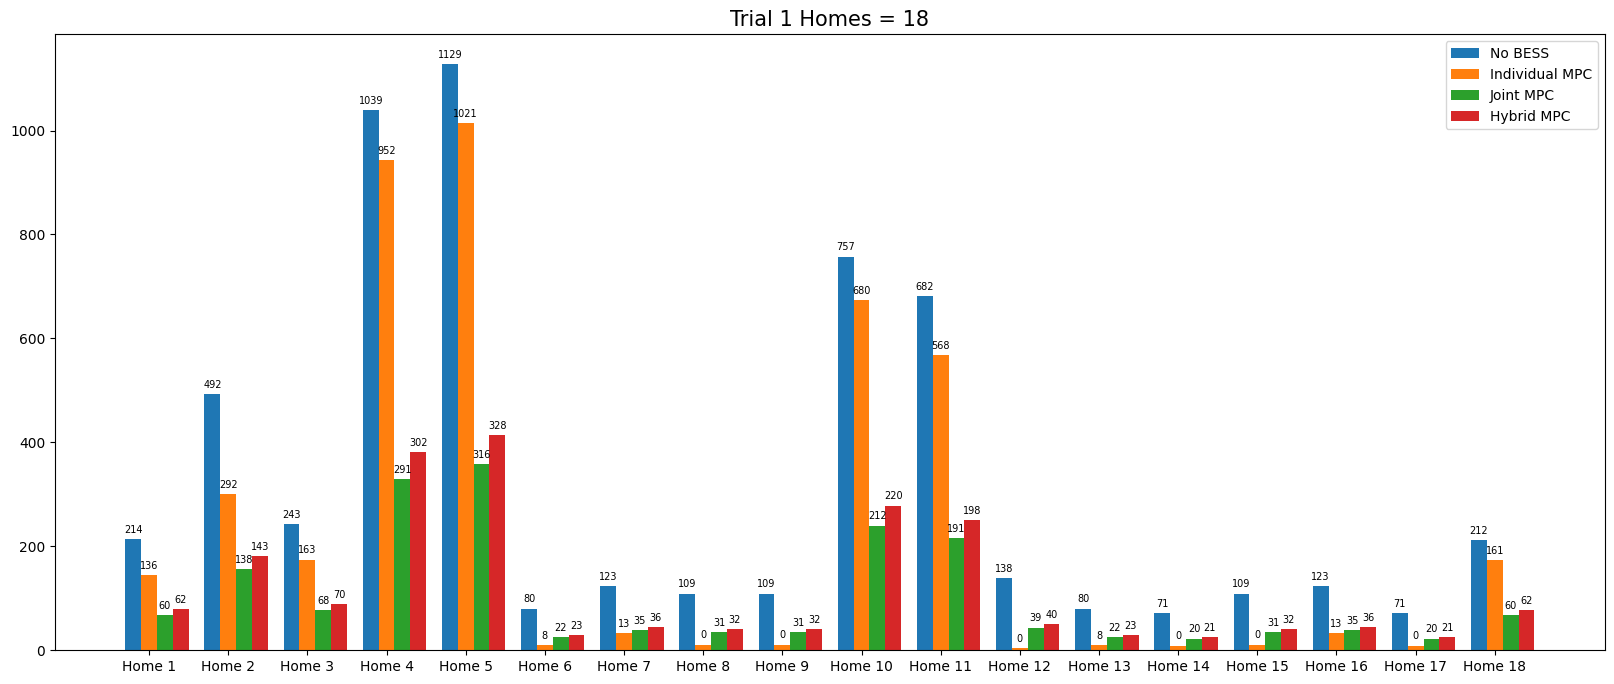

In [22]:
labels_MPC = ["No BESS", "Individual MPC", "Joint MPC", "Hybrid MPC"] 
labels_PF  = ["No BESS", "Individual PF", "Joint PF", "Hybrid PF"]
width = 0.2

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
size    = (mpc_costs.shape[0], mpc_costs.shape[1])
multiplier = [0.2 * i for i in range(size[1])]

for i in range(size[1]):
    rects = ax.bar(np.arange(size[0]) + multiplier[i], mpc_costs[:, i], width = width, label = labels_MPC[i])
    ax.bar_label(rects, labels=np.round(pf_costs[:, i]).astype(int), fontsize=7.0, padding=3)

ax.legend(ncols = 1, loc = "upper right")
ax.set_xticks(np.arange(size[0]) + width, ["Home {}".format(i+1) for i in range(size[0])])
plt.title("Trial {} Homes = {}".format(trial, size[0]), fontsize=15)

plt.savefig("cost_comparison_MPC_ev_forecast_0_trial_{}.png".format(trial))

plt.show()

In [23]:
def plotMeter(mpc, meter_MPC, meter_no_bess, battery_MPC, battery_PF, start_date, case, trial, timesteps = 1344, filename = None) :
    fig, axes = plt.subplots(4, 1, figsize = (10, 16))

    meter_PF  = (meter_no_bess - battery_PF).sum(axis = 1)
    agg_meter = meter_no_bess.sum(axis = 1)

    mask = ((mpc.data_list[0].datetime >= start_date) & 
           (mpc.data_list[0].datetime < start_date + datetime.timedelta(hours = timesteps / 2)))

    loads = np.zeros((timesteps, 1))
    solar = np.zeros((timesteps, 1))

    for home in range(mpc.num_homes):
        loads[:, 0] += mpc.data_list[home].loc[mask, "loads"]
        solar[:, 0] += mpc.data_list[home].loc[mask, "solar"]

    date_labels = [(start_date + datetime.timedelta(days=day*4)).strftime('%m/%d') 
                   for day in range(int(mpc.total_horizon/(mpc.mpc_horizon * 4))+1)]

    print(date_labels)

    # Plot of meter without EV loads
    axes[0].plot(loads - solar, color = '0.7', label = "Aggregate Meter Reading - No Battery or EV loads", linewidth = 2)
    axes[0].axhline(mpc.transformer_limit, linewidth = 1.7, color = mpc.colorset[4])
    axes[0].annotate("Transformer Limit", (270, 27), color = mpc.colorset[4])

    axes[0].set_ylabel("Power [kW]", fontsize = 15)
    axes[0].set_ylim([min(loads - solar) * 1.1, max(loads-solar) * 1.9])
    axes[0].legend(ncols = 2, fontsize = 10, loc = 1)

    axes[0].set_xticks(np.linspace(0, timesteps, 8))
    axes[0].set_xticklabels(date_labels)
    axes[0].tick_params(axis = "both", which = "major", labelsize = 11)

    axes[0].set_title("Case = {} Trial = {} Homes = {}".format(case, trial, mpc.num_homes))

    # Plot of meter with EV loads
    axes[1].plot(loads - solar, color = '0.7', label = "Aggregate Meter Reading - No Battery or EV loads", linewidth = 2)
    axes[1].plot(meter_no_bess.sum(axis = 1), color = "k", label = "Aggregate Meter Reading - No Battery", linewidth = 2)
    axes[1].axhline(mpc.transformer_limit, linewidth = 1.7, color = mpc.colorset[4])
    axes[1].annotate("Transformer Limit", (270, 27), color = mpc.colorset[4])

    axes[1].set_ylabel("Power [kW]", fontsize = 15)
    axes[1].set_ylim([min(loads - solar) * 1.1, max(loads-solar) * 1.9])
    axes[1].legend(ncols = 1, fontsize = 10, loc = 1)

    axes[1].set_xticks(np.linspace(0, timesteps, 8))
    axes[1].set_xticklabels(date_labels)
    axes[1].tick_params(axis = "both", which = "major", labelsize = 11)

    # Plot of meter - PF
    axes[2].plot(meter_no_bess.sum(axis = 1), color = '0.7', label = "Aggregate Meter Reading - No Battery", linewidth = 2)
    axes[2].plot(meter_PF, color = "k", label = "Aggregate Meter Reading - PF", linewidth = 2)
    axes[2].axhline(mpc.transformer_limit, linewidth = 1.7, color = mpc.colorset[4])
    axes[2].annotate("Transformer Limit", (270, 27), color = mpc.colorset[4])

    axes[2].fill_between(np.arange(timesteps), agg_meter, agg_meter + np.maximum(-battery_PF.sum(axis = 1), 0), color = mpc.colorset[2], alpha = .6, label = 'Battery Charge - PF' )
    axes[2].fill_between(np.arange(timesteps), agg_meter, agg_meter + np.minimum(-battery_PF.sum(axis = 1), 0), color = mpc.colorset[1], alpha = .6, label = 'Battery Discharge - PF')

    axes[2].set_ylabel("Power [kW]", fontsize = 15)
    axes[2].set_ylim([min(loads - solar) * 1.1, max(loads-solar) * 1.9])
    axes[2].legend(ncols = 2, fontsize = 10, loc = 1)

    axes[2].set_xticks(np.linspace(0, timesteps, 8))
    axes[2].set_xticklabels(date_labels)
    axes[2].tick_params(axis = "both", which = "major", labelsize = 11)

    # Plot of meter - MPC
    axes[3].plot(meter_no_bess.sum(axis = 1), color = '0.7', label = "Aggregate Meter Reading - No Battery", linewidth = 2)
    axes[3].plot(meter_MPC.sum(axis = 1), color = "k", label = "Aggregate Meter Reading - MPC", linewidth = 2)
    axes[3].axhline(mpc.transformer_limit, linewidth = 1.7, color = mpc.colorset[4])
    axes[3].annotate("Transformer Limit", (270, 27), color = mpc.colorset[4])

    axes[3].fill_between(np.arange(timesteps), agg_meter, agg_meter + np.maximum(-battery_MPC.sum(axis = 1), 0), color = mpc.colorset[2], alpha = .6, label = 'Battery Charge - MPC' )
    axes[3].fill_between(np.arange(timesteps), agg_meter, agg_meter + np.minimum(-battery_MPC.sum(axis = 1), 0), color = mpc.colorset[1], alpha = .6, label = 'Battery Discharge - MPC')

    axes[3].set_ylabel("Power [kW]", fontsize = 15)
    axes[3].set_ylim([min(loads - solar) * 1.1, max(loads-solar) * 1.9])
    axes[3].legend(ncols = 2, fontsize = 10, loc = 1)

    axes[3].set_xticks(np.linspace(0, timesteps, 8))
    axes[3].set_xticklabels(date_labels)
    axes[3].tick_params(axis = "both", which = "major", labelsize = 11)

    # Violation Annotations
    # axes[0].annotate("Violations = {}".format(countViolations(loads - solar, limit=25.5)), (-2, 45), color = "red")
    # axes[1].annotate("Violations = {}".format(countViolations(agg_meter, limit=25.5)), (-2, 45), color = "red")
    # axes[2].annotate("Violations = {}".format(countViolations(meter_PF, limit=25.5)), (-2, 45), color = "red")
    # axes[3].annotate("Violations = {}".format(countViolations(meter_MPC.sum(axis=1), limit=25.5)), (-2, 45), color = "red")

    # plt.savefig("meter_comparison_ev_forecast_0_case_3_trial_1.png")
    if filename != None:
        plt.savefig(filename)
    
    plt.show()

    return

In [24]:
# for trial in range(1, 21):
case  = 1
trial = 1

if case == 3:
    path   = os.getcwd() + "/Code/Results/case_{}/".format(case)
    f1Path = path 
else:
    path   = os.getcwd() + "/Code/Results/case_{}/".format(case)
    f1Path = path + "f1"
    
path1    = os.getcwd() + "/Code/Results/case_{}".format(3)
costPath = path + "cost_list"

soc_PF      = np.loadtxt(f1Path + "/soc_d_{}_ev_forecast_0_trial_{}.csv".format(case, trial))
soc_MPC     = np.loadtxt(f1Path + "/soc_d_{}_mpc_ev_forecast_0_trial_{}.csv".format(case, trial))
meter_PF    = np.loadtxt(f1Path + "/meter_d_{}_ev_forecast_0_trial_{}.csv".format(case, trial))
meter_MPC   = np.loadtxt(f1Path + "/meter_d_{}_mpc_ev_forecast_0_trial_{}.csv".format(case, trial))
battery_PF  = np.loadtxt(f1Path + "/batt_output_d_{}_ev_forecast_0_trial_{}.csv".format(case, trial))
battery_MPC = np.loadtxt(f1Path + "/batt_output_d_{}_mpc_forecast_0_trial_{}.csv".format(case, trial))

cost_no_bess = np.loadtxt(costPath + "/cost_list_{}_no_bess_ev_forecast_0_trial_{}.csv".format(case, trial))
cost_MPC     = np.loadtxt(costPath + "/cost_list_mpc_{}_ev_forecast_0_trial_{}.csv".format(case, trial))
cost_PF      = np.loadtxt(costPath + "/cost_list_determ_{}_ev_forecast_0_trial_{}.csv".format(case, trial))

meter_no_bess = np.loadtxt(path1 + "/meter_d_{}_ev_forecast_0_trial_{}.csv".format(3, trial))

start_date = datetime.datetime(2018, 7, 2, 0 , 0)

if case == 4:
    battery_PF = battery_PF[:-2, :]


# print("cost of no bess = {}".format(cost_no_bess.sum()))
# print("cost of mpc = {}".format(cost_MPC.sum()))
# print("cost of pf = {}".format(cost_PF.sum()))

# printMeter(meter_MPC, battery_MPC, case, isMPC = True)

# print("")

print(countViolations(meter_no_bess.sum(axis = 1), limit=25.5))

#printCost(meter_no_bess, battery_PF, battery_MPC, price_vector, case = case)

115


In [26]:
case_1_costs = np.zeros((50, 3))
case_3_costs = np.zeros((50, 3))
case_4_costs = np.zeros((50, 3))

path = os.getcwd() + "/Code/Results/case_{}/cost_list".format(1)

for trial in range(50):
    case_1_costs[trial, 1:] = np.array(getTotalCosts(1, trial))
    case_3_costs[trial, 1:] = np.array(getTotalCosts(3, trial))
    case_4_costs[trial, 1:] = np.array(getTotalCosts(4, trial))

    cost_no_bess = np.loadtxt(path + "/cost_list_{}_no_bess_ev_forecast_0_trial_{}.csv".format(1, trial))

    case_1_costs[trial, 0] = cost_no_bess.sum()
    case_3_costs[trial, 0] = cost_no_bess.sum()
    case_4_costs[trial, 0] = cost_no_bess.sum()

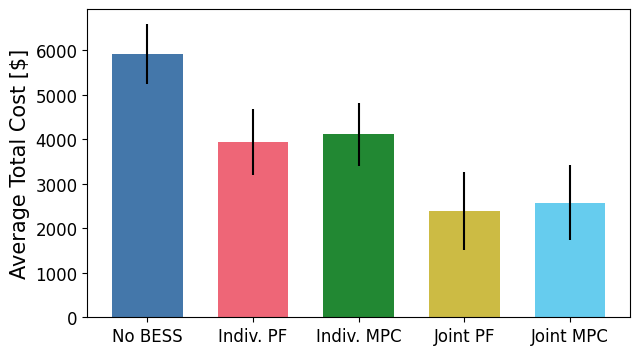

In [30]:
mean_values = [case_1_costs[:, 0].mean(), case_1_costs[:, 1].mean(), case_1_costs[:, 2].mean(), case_3_costs[:, 1].mean(), case_3_costs[:, 2].mean()]
std_values  = [case_1_costs[:, 0].std(), case_1_costs[:, 1].std(), case_1_costs[:, 2].std(), case_3_costs[:, 1].std(), case_3_costs[:, 2].std()]

labels = ["No BESS", "Indiv. PF", "Indiv. MPC", "Joint PF", "Joint MPC"] 
width  = 0.1

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

colorset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']

for i in range(5):
    rects = ax.bar(np.arange(1) + 0.15 * i, mean_values[i], width = width, color = colorset[i], yerr = std_values[i], label = labels[i])

ax.set_ylabel("Average Total Cost [$]", fontsize = 15)

ax.set_xticks([0, .15, .3, .45, .6], labels)

plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

plt.savefig("Figures/5_case_1_3_cost_comparison.pdf", bbox_inches = 'tight')

plt.show()

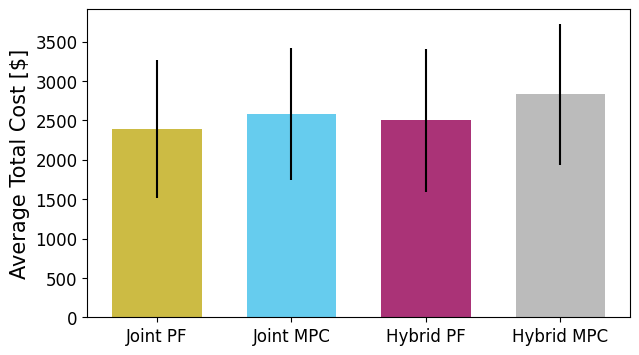

In [31]:
mean_values = [case_3_costs[:, 1].mean(), case_3_costs[:, 2].mean(), case_4_costs[:, 1].mean(), case_4_costs[:, 2].mean()]
std_values  = [case_3_costs[:, 1].std(), case_3_costs[:, 2].std(), case_4_costs[:, 1].std(), case_4_costs[:, 2].std()]

labels = ["Joint PF", "Joint MPC", "Hybrid PF", "Hybrid MPC"] 
width  = 0.1

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

colorset = ['#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']

for i in range(4):
    rects = ax.bar(np.arange(1) + 0.15 * i, mean_values[i], width = width, color = colorset[i], yerr = std_values[i], label = labels[i])

ax.set_ylabel("Average Total Cost [$]", fontsize = 15)

ax.set_xticks([0, .15, .3, .45], labels)

plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

plt.savefig("Figures/7_case_3_4_cost_comparison.pdf", bbox_inches = 'tight')

plt.show()

In [32]:
case_1_costs = np.zeros((50, 3))
case_3_costs = np.zeros((50, 3))
case_4_costs = np.zeros((50, 3))

path = os.getcwd() + "/Code/Results/case_{}/cost_list".format(1)

for trial in range(1, 51):
    case_1_costs[trial-1, 1:] = np.array(getTotalCosts(1, trial))
    case_3_costs[trial-1, 1:] = np.array(getTotalCosts(3, trial))
    case_4_costs[trial-1, 1:] = np.array(getTotalCosts(4, trial))

    cost_no_bess = np.loadtxt(path + "/cost_list_{}_no_bess_ev_forecast_0_jan_trial_{}.csv".format(1, trial))

    case_1_costs[trial-1, 0] = cost_no_bess.sum()
    case_3_costs[trial-1, 0] = cost_no_bess.sum()
    case_4_costs[trial-1, 0] = cost_no_bess.sum()

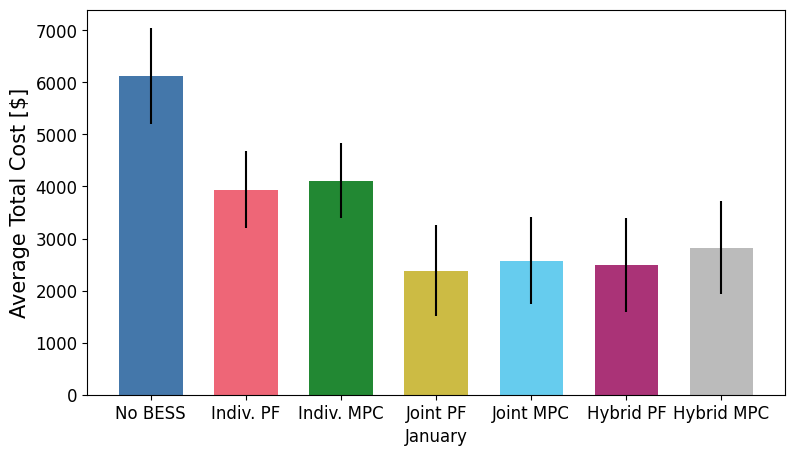

In [35]:
mean_values = [case_1_costs[:, 0].mean(), case_1_costs[:, 1].mean(), case_1_costs[:, 2].mean(), case_3_costs[:, 1].mean(), case_3_costs[:, 2].mean(), case_4_costs[:, 1].mean(), case_4_costs[:, 2].mean()]
std_values  = [case_1_costs[:, 0].std(), case_1_costs[:, 1].std(), case_1_costs[:, 2].std(), case_3_costs[:, 1].std(), case_3_costs[:, 2].std(), case_4_costs[:, 1].std(), case_4_costs[:, 2].std()]

labels = ["No BESS", "Indiv. PF", "Indiv. MPC", "Joint PF", "Joint MPC", "Hybrid PF", "Hybrid MPC"] 
width  = 0.2

fig, ax = plt.subplots(1, 1, figsize=(9, 5))

colorset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']

for i in range(7):
    rects = ax.bar(np.arange(1) + 0.3 * i, mean_values[i], width = width, color = colorset[i], yerr = std_values[i], label = labels[i])

ax.set_ylabel("Average Total Cost [$]", fontsize = 15)

ax.set_xticks([0.3*i for i in range(7)], labels)

plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

ax.set_xlabel("January", fontsize = 12)

plt.savefig("Figures/9_case_all_jan_cost_comparison.pdf", bbox_inches = 'tight')

plt.show()

In [213]:
x = printCost(meter_no_bess, battery_PF, battery_MPC, price_vector, case = case)

(18,)
[213.92, 492.29, 242.54, 1039.16, 1128.7, 80.21, 123.15, 109.09, 109.09, 757.48, 682.09, 138.19, 80.21, 70.97, 109.09, 123.15, 70.97, 212.35]
[2124.91]
[1678.87]


In [77]:
countViolations((meter_PF - battery_PF).sum(axis = 1), limit = 25.5, violation_time_steps=2)

0

In [78]:
countViolations(meter_MPC.sum(axis = 1), limit = 25.5, violation_time_steps=2)

7

In [912]:
countViolations((meter_no_bess - battery_PF).sum(axis = 1), limit = 25.5, violation_time_steps=1)

0

In [144]:
meter_no_bess.sum(axis = 1)[:48]

array([ 30.14 ,  25.484,  22.452,  18.644,  17.868,  16.996,  16.256,
        18.316,  15.86 ,  15.152,  14.9  ,  15.328,  13.644,  13.088,
        12.76 ,  12.452,  12.256,  11.658,  10.424,  19.92 ,   8.924,
         4.128,  -1.508,  -8.868, -11.9  , -18.042, -21.776, -22.224,
       -31.136, -35.582, -34.162, -32.696, -25.198, -20.106, -17.488,
       -12.966, -11.996,  -9.084,  -3.492,   5.112,  15.488,  20.644,
        25.512,  28.792,  28.634,  37.34 ,  38.544,  34.648])

In [50]:
#Figure 2
def ppl(mpc, meter_MPC, meter_no_bess, battery_MPC, battery_PF, start_date, case, trial, timesteps = 1344, filename = None) :
    fig, axes = plt.subplots(2, 1, figsize = (8, 7))

    maxMul = 2.3
    
    meter_PF  = (meter_no_bess - battery_PF).sum(axis = 1)
    agg_meter = meter_no_bess.sum(axis = 1)

    mask = ((mpc.data_list[0].datetime >= start_date) & 
           (mpc.data_list[0].datetime < start_date + datetime.timedelta(hours = timesteps / 2)))

    loads = np.zeros((timesteps, 1))
    solar = np.zeros((timesteps, 1))

    for home in range(mpc.num_homes):
        loads[:, 0] += mpc.data_list[home].loc[mask, "loads"]
        solar[:, 0] += mpc.data_list[home].loc[mask, "solar"]

    #date_labels = [(start_date + datetime.timedelta(days=day*4)).strftime('%m/%d') 
    #               for day in range(int(mpc.total_horizon/(mpc.mpc_horizon * 4))+1)]

    date_labels = [(start_date + datetime.timedelta(days=day*1)).strftime('%m/%d') 
                   for day in range(int(mpc.total_horizon/(mpc.mpc_horizon * 4))+1)]

    print(date_labels)

    # Plot of meter - PF
    axes[0].plot(meter_no_bess.sum(axis = 1), color = '0.7', label = "Aggregate Meter Reading - No Battery", linewidth = 2)
    axes[0].plot(meter_PF, color = "k", label = "Aggregate Meter Reading - PF", linewidth = 2)
    axes[0].axhline(mpc.transformer_limit, linewidth = 1.7, color = mpc.colorset[4])
    axes[0].annotate("Transformer Limit", (0, 27), color = mpc.colorset[4])

    axes[0].fill_between(np.arange(timesteps), agg_meter, agg_meter + np.maximum(-battery_PF.sum(axis = 1), 0), color = mpc.colorset[2], alpha = .6, label = 'Battery Charge - PF' )
    axes[0].fill_between(np.arange(timesteps), agg_meter, agg_meter + np.minimum(-battery_PF.sum(axis = 1), 0), color = mpc.colorset[1], alpha = .6, label = 'Battery Discharge - PF')

    axes[0].set_ylabel("Power [kW]", fontsize = 15)
    #axes[0].set_ylim([min(loads - solar) * 1.1, max(loads-solar) * maxMul])
    axes[0].set_ylim([min(loads - solar) * .8, 85])
    axes[0].legend(ncols = 2, fontsize = 10, loc = 1)

    axes[0].set_xticks(np.linspace(0, timesteps, 8))
    axes[0].set_xticklabels(date_labels)
    axes[0].tick_params(axis = "both", which = "major", labelsize = 11)

    # Plot of meter - MPC
    axes[1].plot(meter_no_bess.sum(axis = 1), color = '0.7', label = "Aggregate Meter Reading - No Battery", linewidth = 2)
    axes[1].plot(meter_MPC.sum(axis = 1), color = "k", label = "Aggregate Meter Reading - MPC", linewidth = 2)
    axes[1].axhline(mpc.transformer_limit, linewidth = 1.7, color = mpc.colorset[4])
    axes[1].annotate("Transformer Limit", (-10, 27), color = mpc.colorset[4])

    axes[1].fill_between(np.arange(timesteps), agg_meter, agg_meter + np.maximum(-battery_MPC.sum(axis = 1), 0), color = mpc.colorset[2], alpha = .6, label = 'Battery Charge - MPC' )
    axes[1].fill_between(np.arange(timesteps), agg_meter, agg_meter + np.minimum(-battery_MPC.sum(axis = 1), 0), color = mpc.colorset[1], alpha = .6, label = 'Battery Discharge - MPC')

    axes[1].set_ylabel("Power [kW]", fontsize = 15)
    #axes[1].set_ylim([min(loads - solar) * 1.1, max(loads-solar) * maxMul])
    axes[1].set_ylim([min(loads - solar) *.8, 85])
    axes[1].legend(ncols = 2, fontsize = 10, loc = 1)

    axes[1].set_xticks(np.linspace(0, timesteps, 8))
    axes[1].set_xticklabels(date_labels)
    axes[1].tick_params(axis = "both", which = "major", labelsize = 11)

    axes[0].axhline(0, linewidth = 1.0, color = "black")
    axes[1].axhline(0, linewidth = 1.0, color = "black")

    # Violation Annotations
    # axes[0].annotate("Violations = {}".format(countViolations(loads - solar, limit=25.5)), (-2, 45), color = "red")
    # axes[1].annotate("Violations = {}".format(countViolations(agg_meter, limit=25.5)), (-2, 45), color = "red")
    # axes[2].annotate("Violations = {}".format(countViolations(meter_PF, limit=25.5)), (-2, 45), color = "red")
    # axes[3].annotate("Violations = {}".format(countViolations(meter_MPC.sum(axis=1), limit=25.5)), (-2, 45), color = "red")

    # plt.savefig("meter_comparison_ev_forecast_0_case_3_trial_1.png")
    if filename != None:
        plt.savefig(filename, bbox_inches = "tight")
    
    plt.show()

    return

['07/02', '07/03', '07/04', '07/05', '07/06', '07/07', '07/08', '07/09']


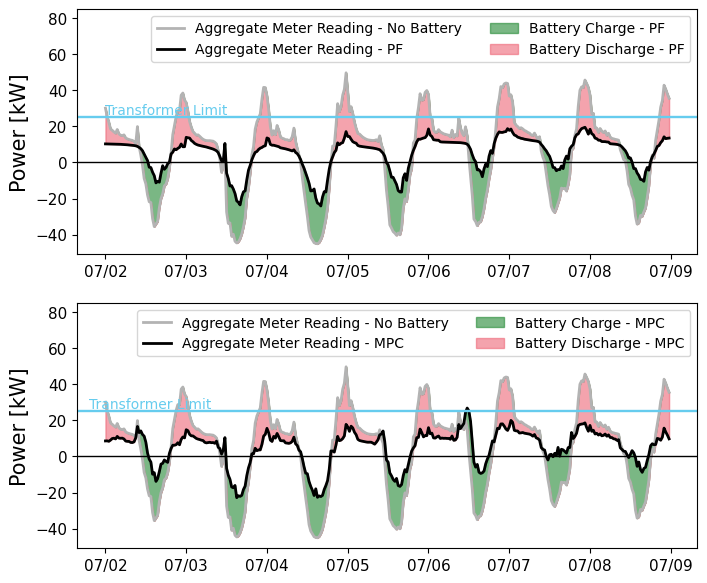

In [51]:
ppl(mpc, meter_MPC[:24*14], meter_no_bess[:24*14], battery_MPC[:24*14], battery_PF[:24*14], start_date, case = case, trial = trial, 
          filename = "meter_comparison_case_{}_trial_{}_ev_forecast_0.png".format(case, trial), timesteps=24*14)

In [504]:
printMeter(meter_MPC, battery_MPC, case, isMPC = True)

the max meter = 29.27784061908273
the min meter = -10.173500861728378


In [458]:
cost_PF

array([ 44.18672562, 155.77671814, 272.85980225, 329.1473999 ,
       113.32865906,  35.57784271, 273.14974976,  58.37117767,
        67.31550598, 119.43216705, 117.40814209, 493.224823  ,
       184.30046082, 295.85003662,  67.31550598,  45.2912941 ,
       236.99102783])

In [462]:
cost_MPC - cost_PF

array([ 39.76301042, 140.18127334, 245.54268981, 296.19510213,
       101.98285166,  32.01599681, 245.80359288,  52.527399  ,
        60.57626528, 107.4753146 , 105.65392891, 443.84601801,
       165.84936613, 266.23126131,  60.57626528,  40.75699216,
       213.26488476])

In [31]:
def getForecast(data, start, timesteps, dt = 0.5, forecast_period = 4):
    loads_actual = np.zeros((timesteps, 1))
    solar_actual = np.zeros((timesteps, 1))
    
    loads_forecast = np.zeros((timesteps, 1))
    solar_forecast = np.zeros((timesteps, 1))
    
    for timestep in range(timesteps):
        ix = []
        for day in range(forecast_period):
            ix.append(np.where(data.loc[:, 'datetime'] == start - datetime.timedelta(days  = forecast_period) + 
                                                                  datetime.timedelta(hours = timestep * dt) + 
                                                                  datetime.timedelta(days  = day))[0][0])
        loads_forecast[timestep, 0] = np.average(data.loc[ix, "loads"])
        solar_forecast[timestep, 0] = np.average(data.loc[ix, "solar"])

    mask = (data.datetime >= start) & (data.datetime < start + datetime.timedelta(hours = timesteps / 2))
    
    solar_actual[:, 0] = data.loc[mask, 'solar']
    loads_actual[:, 0] = data.loc[mask, 'loads']

    dates = data.loc[mask, "datetime"].reset_index(drop = True)

    return loads_forecast, solar_forecast, loads_actual, solar_actual, dates

In [32]:
x = getForecast(mpc.data_list[3], start_date, mpc.num_mpc_iters, forecast_period=4)

loads_forecast = x[0]
solar_forecast = x[1]

loads_actual = x[2]
solar_actual = x[3]

dates = x[4]

NameError: name 'mpc' is not defined

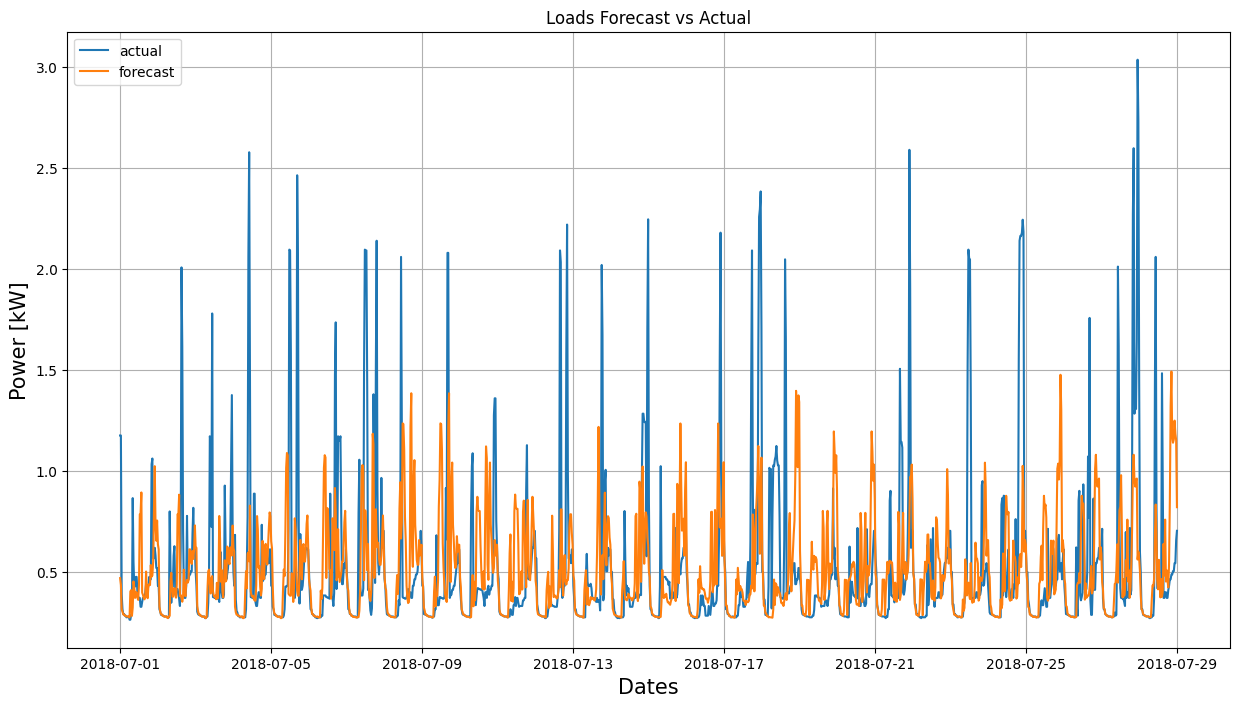

In [86]:
plt.figure(figsize = (15, 8))
plt.plot(dates, loads_actual,   label = "actual")
plt.plot(dates, loads_forecast, label = "forecast")

plt.xlabel("Dates", fontsize = 15)
plt.ylabel("Power [kW]", fontsize = 15)

plt.title("Loads Forecast vs Actual")

plt.legend()
plt.grid()

plt.show()

In [30]:
def createPriceVector(mpc, dates, timesteps):
    price_vector = np.zeros((timesteps, 1))

    for timestep in range(timesteps):
        if dates[timestep].month >= 6 and dates[timestep].month < 10: 
            if dates[timestep].hour < 15:
                price_vector[timestep] = mpc.off_peak_summer
            elif dates[timestep].hour == 15 or dates[timestep].hour >= 21:
                price_vector[timestep] = mpc.peak_summer
            else:
                price_vector[timestep] = mpc.partial_peak_summer
        else:
            if dates[timestep].hour < 15:
                price_vector[timestep] = mpc.off_peak_winter
            elif dates[timestep].hour == 15 or dates[timestep].hour >= 21:
                price_vector[timestep] = mpc.peak_winter
            else:
                price_vector[timestep] = mpc.partial_peak_winter

    return price_vector

In [88]:
price_vector = createPriceVector(mpc, dates, mpc.num_mpc_iters)

In [710]:
meter_no_bess.T.shape

(17, 1488)

In [708]:
price_vector.shape

(1488, 1)

In [1353]:
print( np.sum((np.maximum(meter_no_bess, 0) * mpc.dt).T @ price_vector) )

print( np.sum((np.maximum(meter_MPC.sum(axis = 1), 0) * mpc.dt).T @ price_vector) )

print( np.sum((np.maximum(meter_no_bess.sum(axis = 1) - battery_PF[:-2, :].sum(axis = 1), 0) * mpc.dt).T @ price_vector) )

6785.81452
3099.316486524479


ValueError: operands could not be broadcast together with shapes (1488,) (1486,) 

In [776]:
meter_MPC.sum(axis = 1)

array([18.31650025, 18.15061762, 16.78483347, ...,  3.35099989,
       -0.65600011, -2.75650012])

In [770]:
obj = (np.maximum(meter_PF.sum(axis = 1) - battery_MPC.sum(axis = 1), 0) * mpc.dt).T @ price_vector

In [771]:
print(obj)

[3099.31648652]


In [751]:
orig_costs = np.zeros((mpc.num_homes, ))
for home in range(mpc.num_homes):
    orig_costs[home] = np.maximum(meter_PF[:, home] - battery_PF[:, home]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [33]:
def getFiles(trials = 20, homes = 11):
    folder_path = "/Data_L2/csv/"
    files = os.listdir(os.getcwd() + folder_path)
    files = [file for file in files if "loads" not in file]
    files = [os.getcwd() + folder_path + file for file in files]
    
    filenames = [random.sample(files, homes) for i in range(trials)]

    return filenames

In [34]:
filenames = getFiles()
#print(filenames)

In [35]:
data = []
for home_file in filenames[0]:
    print("opening {} and storing into array".format(home_file))
    data.append(process_data(home_file, add_EV_to_loads = False))

opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/540601-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/146132-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/467487-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/481945-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/58178-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/285819-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/371969-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/99152-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/89892-0.csv and storing into array
opening /home/obi/Documents/Res

In [323]:
(meter_PF.sum(axis = 1) - battery_PF.sum(axis = 1)).min()

-50.34340531918811

In [406]:
def sizeSolar(data, average_peak_hours = 5.3, inefficiency_factor = 1.2):
    ev_kWh    = sum(data.ev) / 2
    loads_kWh = sum(data.loads) / 2
    daily_kWh = (ev_kWh + loads_kWh) / 365

    return round(daily_kWh / average_peak_hours * inefficiency_factor, 2)

In [430]:
for ix in range(len(data)):
    maxSolar      = data[ix].solar.max()
    currSolarSize = sizeSolar(data[ix])

    if currSolarSize > maxSolar:
        ratio = currSolarSize / maxSolar
        print(ix, ratio)
        data[ix].solar *= ratio

0 3.7037037037037037
1 3.079534432589719
2 5.87962962962963
3 3.311599176389842
4 12.548076923076923
5 8.066037735849056
6 3.7359999999999998
7 1.798888888888889
8 2.4774774774774775
9 5.315533980582525
10 7.118055555555555


In [407]:
for ix in range(len(data)):
    maxSolar      = data[ix].solar.max()
    currSolarSize = sizeSolar(data[ix])

    if currSolarSize > maxSolar:
        ratio = currSolarSize / maxSolar
        print(ix, ratio)
        data[ix].solar *= ratio

0 2.3957797220792587
1 1.8558951965065504
2 4.552238805970149
3 2.3753867308353387
4 6.742788461538463
5 5.930531732418525
6 1.8123496391339213
7 1.2480551233607466
8 1.6169844020797228
9 3.3211974110032365
10 5.483259633607075


In [36]:
experiment_file = "/Code/Experiments/case3_9_homes.json"
mpc = MPC(data, os.getcwd() + experiment_file)

In [40]:
def plotData(data, start_date, length):
    ix  = np.where(data.datetime == start_date)[0][0]
    fig = plt.figure(figsize = (8, 8))

    plt.plot(data.datetime[ix:ix+length], data.solar[ix:ix+length])
    plt.show()
    return

In [410]:
length = 1488
solar = np.zeros((length, 11))
loads = np.zeros((length, 11))

for i in range(len(mpc.data_list)):
    ix = np.where(mpc.data_list[i].datetime == start_date)[0][0]

    solar[:, i] += mpc.data_list[i].solar[ix:ix+length]
    loads[:, i] += mpc.data_list[i].loads[ix:ix+length]
    loads[:, i] += mpc.data_list[i].ev[ix:ix+length]

solar = np.array(solar)
loads = np.array(loads)

In [462]:
for trial in range(1, 11):
    data  = []
    print("trial {}".format(trial))
    for home_file in filenames[trial]:
        print("opening {} and storing into array".format(home_file))
        data.append(process_data(home_file, add_EV_to_loads = False))

    experiment_file = "/Code/Experiments/case1_9_homes.json"
    mpc = MPC(data, os.getcwd() + experiment_file)

    output = mpc.full_deterministic(start_date)
    print("the max meter = {} and min meter = {}".format(output[0].sum(axis = 1).max(), output[0].sum(axis = 1).min()))

trial 1
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/329469-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/201857-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/242363-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/260594-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/59645-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/467487-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/196838-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/497707-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/371969-0.csv and storing into array
opening /home/obi/Doc

In [454]:
case  = 3
# trial = 1

path = os.getcwd() + "/Code/Results/case_{}_9_homes_l2/f1".format(case)

for trial in range(2, 10):
    cost_no_bess = np.loadtxt(path + "/cost_list_{}_no_bess_ev_forecast_0_trial_{}.csv".format(case, trial))
    print("trial = {} and cost = {}".format(trial, cost_no_bess.sum()))

trial = 2 and cost = 3973.1907791970025
trial = 3 and cost = 2895.4108247546737
trial = 4 and cost = 4159.998604878297
trial = 5 and cost = 2233.2985905124597
trial = 6 and cost = 3281.860546857495
trial = 7 and cost = 3741.8868075159935
trial = 8 and cost = 3271.9785399714024
trial = 9 and cost = 2884.863141928113


In [479]:
(meter_PF + battery_PF).sum(axis = 0)

array([ -677.136,  1112.75 ,  2735.092,  2750.984,  1131.766,  2692.446,
          27.334, -2237.094,    -8.154,  1026.81 ,  4427.974])

In [457]:
output = mpc.full_deterministic(start_date)

43.522000000000006
-22.090000000000003
-7.137569441850566
Total full deterministic cost is:  3866.5835
cost of each home is:  [2.8614087e+02 6.1398938e+02 5.8800008e-02 1.9226900e+01 3.1049915e+02
 1.4951790e+02 1.1397604e+02 1.7974352e+02 1.0411587e+03 1.1426488e+03
 9.6236000e+00]


In [746]:
battery_PF.sum(axis = 1)

array([19.01985021, 16.76943481, 12.14064255, ..., 38.03235453,
       31.29290348, 29.48773061])

In [263]:
importlib.reload(Code.case_3)

<module 'Code.case_3' from '/home/obi/Documents/Research/transformer_protection/Code/case_3.py'>

(1488,) (1488,)
744
24


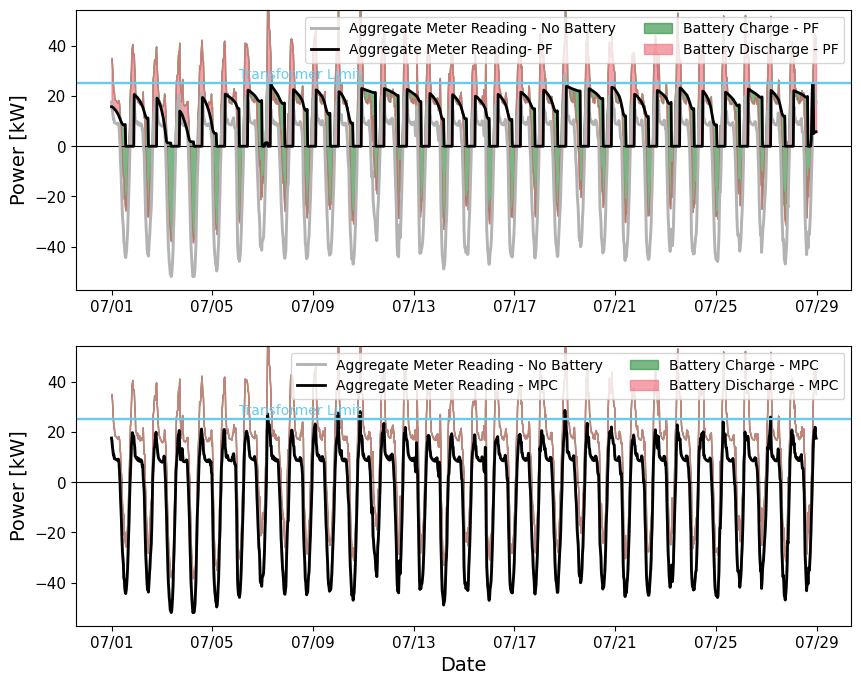

In [145]:
Code.case_3.plot_case_3(mpc, loads-solar, np.zeros((1488, 1)), soc_MPC, output[0], output[1], soc_PF, start_date)

In [142]:
(loads-solar).sum(axis = 1)

array([17.56 , 16.394, 13.998, ..., 21.908, 18.464, 17.544])

In [47]:
countViolations(meter_no_bess.sum(axis =1), limit = 25, violation_time_steps=2)

3

In [36]:
july_folder_path = "/Data_L2/csv/july/"
files0 = os.listdir(os.getcwd() + july_folder_path)
files0 = [file for file in files0 if "loads" not in file]
files0 = [os.getcwd() + july_folder_path + file for file in files0]

folder_path = "/Data_L2/csv/"
files = os.listdir(os.getcwd() + folder_path)
files = [file for file in files if "loads" not in file and "july" not in file]
files = [os.getcwd() + folder_path + file for file in files]

In [33]:
def reshapeData(data, start_date, timeHorizon = 744):
    df = pd.DataFrame(columns = ["datetime", "solar", "loads", "ev"])
    dt = (data.datetime[1].minute - data.datetime[0].minute) / 60
    sr = int(0.5 / dt)

    df.datetime = data.datetime[1::sr]
    df.solar    = np.average(np.array(data.solar).reshape(-1, sr), axis = 1)
    df.loads    = np.average(np.array(data.loads).reshape(-1, sr), axis = 1)
    df.ev       = np.average(np.array(data.ev).reshape(-1, sr), axis = 1)

    mask = (df.datetime >= start_date) & (df.datetime < start_date + datetime.timedelta(hours = timeHorizon))

    return df[mask].reset_index(drop = True)
    #return df.reset_index(drop = True)

In [106]:
reshapeData(dat0, start_date, timeHorizon = 672)

,datetime,solar,loads,ev
0,2018-07-02 00:00:00,0.000,0.844,0.0
1,2018-07-02 00:30:00,0.000,0.756,0.0
2,2018-07-02 01:00:00,0.000,0.756,0.0
3,2018-07-02 01:30:00,0.000,0.648,0.0
4,2018-07-02 02:00:00,0.000,0.640,0.0
...,...,...,...,...
1339,2018-07-29 21:30:00,0.298,0.712,0.0
1340,2018-07-29 22:00:00,0.172,0.780,0.0
1341,2018-07-29 22:30:00,0.000,0.804,0.0
1342,2018-07-29 23:00:00,0.000,0.804,0.0


In [38]:
hours = 672
start_date = datetime.datetime(2018, 1, 8, 0 , 0)

for file in files:
    dat0 = process_data(file, add_EV_to_loads=False)
    reshapeData(dat0, start_date, timeHorizon = hours).to_csv(os.getcwd() + folder_path + "jan/" + file.split("/")[-1], index = False)

In [156]:
random.seed(50)
for i in range(20):
    start_date = datetime.datetime(2018, 7, 2, 0 , 0)
    
    iters = 1488
    
    solar = np.zeros((iters, 1))
    loads = np.zeros((iters, 1))
    
    count = 0
    violations = 0
    
    names = []
    
    while violations == 0:
        count += 1
        
        file = random.sample(files0, 1)
        #print("opening file = {}".format(file))
        
        # data = reshapeData(process_data(file[0], add_EV_to_loads=False), start_date)
        # mask = (data.datetime >= start_date) & (data.datetime < start_date + datetime.timedelta(hours = 744))
    
        data = pd.read_csv(file[0])
    
        # solar[:, 0] += data.loc[mask, "solar"]
        # loads[:, 0] += data.loc[mask, "loads"]
    
        solar[:, 0] += data.solar / (30/60)
        loads[:, 0] += data.loads / (30/60)
    
        violations = countViolations(loads - solar)
        names.append(file)
    
        # print("just finished testing {} homes".format(count))
    
    print("trial = {} total homes = {} and total violations = {}".format(i+1, count, violations))

trial = 1 total homes = 7 and total violations = 1
trial = 2 total homes = 7 and total violations = 1
trial = 3 total homes = 8 and total violations = 26
trial = 4 total homes = 8 and total violations = 1
trial = 5 total homes = 8 and total violations = 1
trial = 6 total homes = 7 and total violations = 1
trial = 7 total homes = 10 and total violations = 2
trial = 8 total homes = 10 and total violations = 1
trial = 9 total homes = 7 and total violations = 1
trial = 10 total homes = 7 and total violations = 1
trial = 11 total homes = 5 and total violations = 1
trial = 12 total homes = 7 and total violations = 1
trial = 13 total homes = 8 and total violations = 2
trial = 14 total homes = 9 and total violations = 1
trial = 15 total homes = 9 and total violations = 1
trial = 16 total homes = 8 and total violations = 1
trial = 17 total homes = 10 and total violations = 1
trial = 18 total homes = 6 and total violations = 2
trial = 19 total homes = 8 and total violations = 1
trial = 20 total 

In [122]:
[x[0].split("july/")[0] + x[0].split("july/")[1] for x in names]

['/home/obi/Documents/Research/transformer_protection/Data_L2/csv/138546-0.csv',
 '/home/obi/Documents/Research/transformer_protection/Data_L2/csv/439994-0.csv',
 '/home/obi/Documents/Research/transformer_protection/Data_L2/csv/108199-0.csv',
 '/home/obi/Documents/Research/transformer_protection/Data_L2/csv/59645-0.csv',
 '/home/obi/Documents/Research/transformer_protection/Data_L2/csv/231203-0.csv',
 '/home/obi/Documents/Research/transformer_protection/Data_L2/csv/6433-0.csv',
 '/home/obi/Documents/Research/transformer_protection/Data_L2/csv/102808-0.csv',
 '/home/obi/Documents/Research/transformer_protection/Data_L2/csv/329469-0.csv',
 '/home/obi/Documents/Research/transformer_protection/Data_L2/csv/467487-0.csv',
 '/home/obi/Documents/Research/transformer_protection/Data_L2/csv/481859-0.csv',
 '/home/obi/Documents/Research/transformer_protection/Data_L2/csv/99152-0.csv',
 '/home/obi/Documents/Research/transformer_protection/Data_L2/csv/89892-0.csv',
 '/home/obi/Documents/Research/tr

In [140]:
random.seed(50)
# filenames = [random.sample(files, 1)[0] for i in range(count)]
filenames = [random.sample(files, 1)[0] for i in range(count)]

data = []
for home_file in filenames:
    print("opening {} and storing into array".format(home_file))
    data.append(process_data(home_file, add_EV_to_loads = False))
    # data0.append(pd.read_csv(home_file))
    # data0[-1].datetime = pd.to_datetime(data0[-1].datetime)

opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/138546-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/439994-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/108199-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/59645-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/231203-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/6433-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/102808-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/329469-0.csv and storing into array
opening /home/obi/Documents/Research/transformer_protection/Data_L2/csv/467487-0.csv and storing into array
opening /home/obi/Documents/Res

In [268]:
data[0].datetime

0      2018-07-01 00:15:00
1      2018-07-01 00:45:00
2      2018-07-01 01:15:00
3      2018-07-01 01:45:00
4      2018-07-01 02:15:00
               ...        
1483   2018-07-31 21:45:00
1484   2018-07-31 22:15:00
1485   2018-07-31 22:45:00
1486   2018-07-31 23:15:00
1487   2018-07-31 23:45:00
Name: datetime, Length: 1488, dtype: datetime64[ns]

In [142]:
experiment_file = "/Code/Experiments/case3_9_homes.json"
mpc = MPC(data, os.getcwd() + experiment_file)

In [143]:
mpc.batt_energy  = [13.5] * count
mpc.chg_power    = [5] * count
mpc.dischg_power = [5] * count
mpc.num_homes    = count

mpc.reshape_data()

In [144]:
mpc.fraction = [0.5] * count